In [1017]:
from scipy.stats import beta
import pymc as pm
from pymc import rbeta
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt

# Sample Class
מחלקה 

In [1018]:
class Sample(object):
    def __init__(self, q, n=1000000):
        self.q = q
        self.n = n
        self.G = int(np.ceil(q*n))
        self.B = n - self.G
        self.line = self.generate()
        
    def generate(self, from_file = None, seed=2016):
        self.seed = seed
        
        if from_file:
            name = "./samples/{}_{}.txt".format(str(self.q).replace(".",""),str(self.seed))
            self.line = np.loadtxt(name, dtype=np.int8)
            
        seed = np.random.seed(seed)
        line = np.append(np.ones(self.G, dtype = np.int8), np.zeros(self.B, dtype = np.int8))
        self.line = np.random.permutation(line)
        return self.line
    
    def save(self):
        name = "./samples/{}_{}.txt".format(str(self.q).replace(".",""),str(self.seed))
        np.savetxt(name, self.line,fmt="%d")

In [1019]:
class Strategy(object):
    '''Gets a sample object and builds a test plan'''
    def __init__(self, sample, startig_test=1):
        self.q = beta(1,1)
        self.sample = sample
        self.queue = sample.line
        self.Ntests = 0
        self.Htests = 0
        self.test_now = startig_test
        self.G = 0
        self.B = 0
        self.q_history = []
        self.H_history = []
        self.name = ""
        self.gsize = 0
        self.failed_h = 0
    def test(self):
        '''test needs to be implemented according to the relevant strategy'''
        pass
        raise NotImplementedError()
        
        
    def g_test(self, items):
        
        if items.size == 1:
            return
        self.gsize += 1
        self.Ntests += 1
        m = int(items.size/2)
        test, leave = np.split(items, [m])
        if all(test):
            self.G += test.size
            self.g_test(leave)
        else:
            # Leave is now binomial and back to queue
            self.queue = np.append(leave, self.queue)
            self.g_test(test)
    
    def update(self, h_now):
        '''updates all histories'''
        self.Ntests += 1
        self.Htests += 1
        self.H_history.append(h_now)
        self.q_history.append(self.G / ( 1+ self.G + self.B))
        
    def plot(self, fig = None):
        l = len(self.H_history)
        if fig is None:
            fig, ax = plt.subplots(2,figsize=(16,12))
        ax = fig.get_axes()
        
        # Axis 0 - q History
        ax[0].set_title("q History")
        ax[0].plot(self.q_history, label=self.name)
        ax[0].set_xlim(0,l)
        ax[0].legend(loc='best')
        
        # Axis 1 - H history
        ax[1].set_title("H History")
        ax[1].plot(self.H_history[::1], label = self.name)
#         ax[1].plot([0,l],[np.mean(self.H_history)]*2, ls='--', lw=2, c='b',
#                    label="{} Mean = {:.4f}".format(self.name, np.mean(self.H_history)))
        ax[1].set_xlim(0,l)
        ax[1].legend()
        
        
        return fig, ax
    
# Double or Divide Strategy
class DOD(Strategy):
    def test(self):
        self.name = "Double or Divide"
        h_now = self.test_now
        while self.queue.size > 0:
            # Update histories
            self.update(h_now)
            items, self.queue = np.split(self.queue,[h_now])
            if all(items):
                self.G += items.size
                h_now *= 2
            else:
                self.B +=1
                self.g_test(items)
                h_now = max(1, h_now//2)

class Xwise(Strategy):
    '''Implements a constant test of size :starting_test:'''
    def test(self):
        h_now = self.test_now
        self.name = "{}-wise".format(h_now)
        while self.queue.size > 0:
            self.update(h_now)
            items, self.queue = np.split(self.queue,[h_now])
            if all(items):
                self.G += items.size
            else:
                self.B += 1
                self.g_test(items) 
#                 print (self.gsize, end=" ")
                self.failed_h += 1
        self.gsize /= self.failed_h
                
class OneByOne(Xwise):
    def test(self):
        self.test_now = 1
        super().test()
        self.name = "One by One"


                
class Pairwise(Xwise):
    def test(self):
        self.test_now = 2
        super().test()
        self.name = "Pairwise"
                
class NonAdaptiveDecision(Strategy):
    def test(self):
        self.name = "Non Adaptive"
        h_now = self.test_now
        after = 1000
        while self.queue.size > 0:
            # Update histories
            self.update(h_now)
            last_q = self.q_history[-1]
            if (self.G + self.B > after) and (last_q < 0.835):
                break
            items, self.queue = np.split(self.queue,[h_now])
            if all(items):
                self.G += items.size
                h_now *= 2
            else:
                self.B +=1
                self.g_test(items)
                h_now = max(1, h_now//2)
                
        if last_q < 0.618:
            # Do one by one
            self.name += " -> 1by1"
            while self.queue.size > 0:
                self.update(1)
                items, self.queue = np.split(self.queue,[1])
                if all(items):
                    self.G += items.size
                else:
                    self.B +=1
        elif last_q < 0.835:
            # Do Pairwise
            self.name += " -> pairwise"
            while self.queue.size > 0:
                self.update(2)
                items, self.queue = np.split(self.queue,[2])
                if all(items):
                    self.G += items.size
                else:
                    self.B += 1
                    self.g_test(items)
        else:
            self.name += " -> DOD"
            
class Langsam(Strategy):
    '''Langsam Adaptive Bayesian strategy.'''
    def test(self, function_g = lambda x: x, function_b = lambda x: 1,seed = 2):
        '''function_g and function_b are the functions on number of goods or number of bads to add to
        the beta draw. Default is H-test if GOOD, or 1 if BAD'''
#         np.random.seed(seed)
#         pm.numpy.random.seed(seed)
        self.name = "Langsam Adaptive Bayesian"
        l = 10
        powers = np.arange(0,l,1)
#         sizes = 2**powers
        sizes = np.array([1,2,3,4,5,6,7,8,9,10,15,20,25,30])
        l = len(sizes)
        Gs = np.zeros(l)
        Bs = np.zeros(l)
        choice_history = []
        
        
        f = open('./test.txt', 'w')
        f2 = open('./draws.txt', 'w')
        while self.queue.size > 0:
            draw = rbeta(1 + np.log2(sizes) + Gs, 1 + Bs)
#             f2.write("{}\n\n".format(draw))
            draw = np.argmax(draw)
            h_now = sizes[draw]
            choice_history.append(h_now)
            
            f.write ("{} ".format(h_now))
            # Update histories
            self.update(h_now)
            q_now = self.q_history[-1]
            items, self.queue = np.split(self.queue,[h_now])
            if all(items):
                self.G += items.size
#                 Gs[draw] += function_g(items.size)
                Gs[draw] += (draw+1)/10
                f.write ("SUCCESS ")
                # Update
            else:
                f.write ("_______ ")
                self.B += 1
                self.g_test(items)
#                 Bs[draw] += function_b(items.size)
                Bs[draw] += 1 / (1 + draw)
            f.write ("({:.3f},{:.3f})\n".format((np.log2(sizes) + 1 + Gs)[draw], 1 + Bs[draw]))
        f.close()
        f2.close
#         print(sizes,'\n',1 + Gs,'\n', 1 + Bs)
#         print (np.histogram(choice_history, bins=sizes)[0])
# #         print (choice_history)
#         print()
        self.choices = choice_history
    
    def hist(self):
        fig, ax = plt.subplots()
        ax.hist(self.choices, bins=2**np.arange(0,10,1))

Real:  7070 2930 

One by One      0.0
Goods   | Bads     | Tests    | H-Tests | Mean H-Test
 7070   |  2930    | 10000    | 10000   | 1.0000 

Pairwise      1.0
Goods   | Bads     | Tests    | H-Tests | Mean H-Test
 7070   |  2930    |  8790    |  5860   | 2.0000 

3-wise      1.5539249146757679
Goods   | Bads     | Tests    | H-Tests | Mean H-Test
 7070   |  2930    |  9079    |  4526   | 3.0000 

Double or Divide      4327
Goods   | Bads     | Tests    | H-Tests | Mean H-Test
 7070   |  2930    |  9757    |  5430   | 2.7232 

Langsam Adaptive Bayesian      8610
Goods   | Bads     | Tests    | H-Tests | Mean H-Test
 7070   |  2930    | 11894    |  3284   | 9.4373 



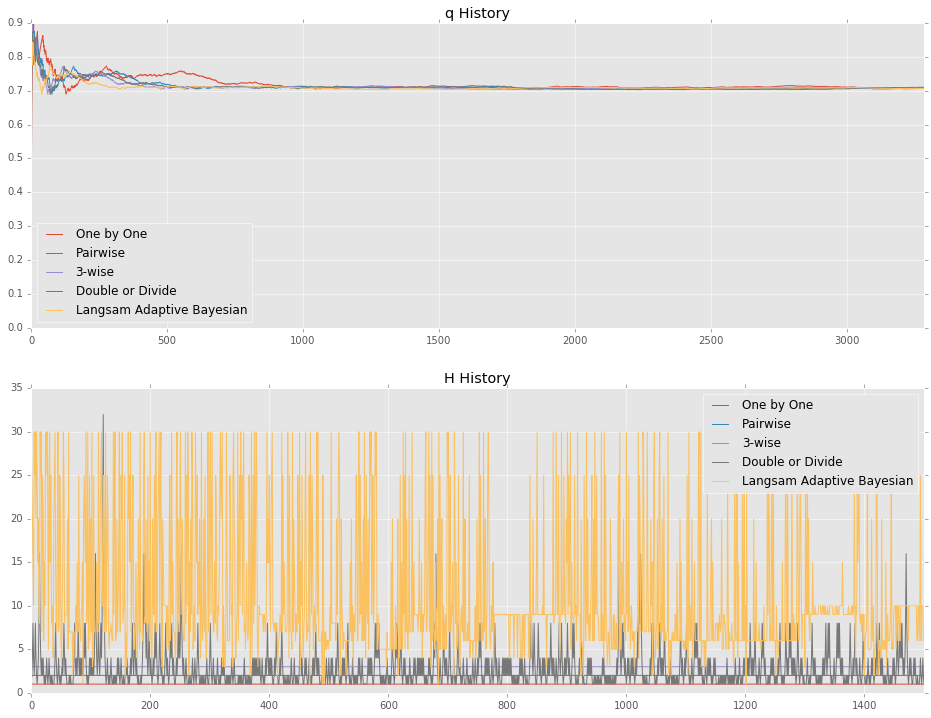

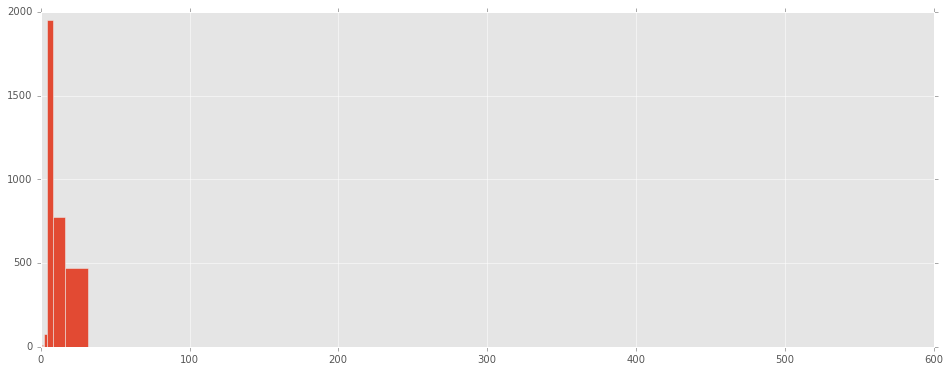

In [936]:
s = Sample(0.707, n=10000)
# s.generate(seed=np.random.randint(100,400))
# strats = [DOD, NonAdaptiveDecision,OneByOne, Pairwise]

# strats = [OneByOne(s), Pairwise(s), Xwise(s, 22), Xwise(s,31), Xwise(s,32), Xwise(s,66)]
strats = [OneByOne(s), Pairwise(s), Xwise(s, 3), DOD(s), Langsam(s)]
fig = None
print("Real: ",s.G, s.B,'\n')
for strat in strats:
    policy = strat
    policy.test()
    print (policy.name, '    ', policy.gsize)
    print ("======================================================")
    if policy.queue.size != 0:
        print ("WARNING: Does not finish")
    print ("Goods   | Bads     | Tests    | H-Tests | Mean H-Test")
    print ("{:5d}   | {:5d}    | {:5d}    | {:5d}   | {:.4f} ".format(policy.G, policy.B,
                                                       policy.Ntests, policy.Htests,
                                                       np.mean(policy.H_history)))
    print()
    fig, ax = policy.plot(fig)
    try:
        policy.hist()
    except:
        pass
ax[1].set_xlim(0,1500)
# ax[1].set_ylim(0,100)
plt.show()

# Different q comparison

In [999]:
from tqdm import tqdm

In [1016]:

mean_test = np.zeros((0,5))
qs = np.append(np.arange(0.001,0.6,0.1), np.arange(0.6,1,0.001))
# print (qs)
l = 16 # Equal len(strats)
mean_test = np.zeros((0,l))
for q in tqdm(qs):
    s = Sample(q, n=5000)
#     strats = [OneByOne(s), Pairwise(s), Xwise(s, 3), Xwise(s, 4), Xwise(s, 8)]#, DOD(s), Langsam(s)]
    strats = [Xwise(s, i+1) for i in range(l)]
    new_row = np.zeros(l)
    for i, s in enumerate (strats):
        s.test()
        new_row[i] = s.Ntests
    mean_test = np.vstack((mean_test, new_row))
#     print (q, end=" ")
# mean_test

100%|██████████| 406/406 [07:41<00:00,  3.98it/s]


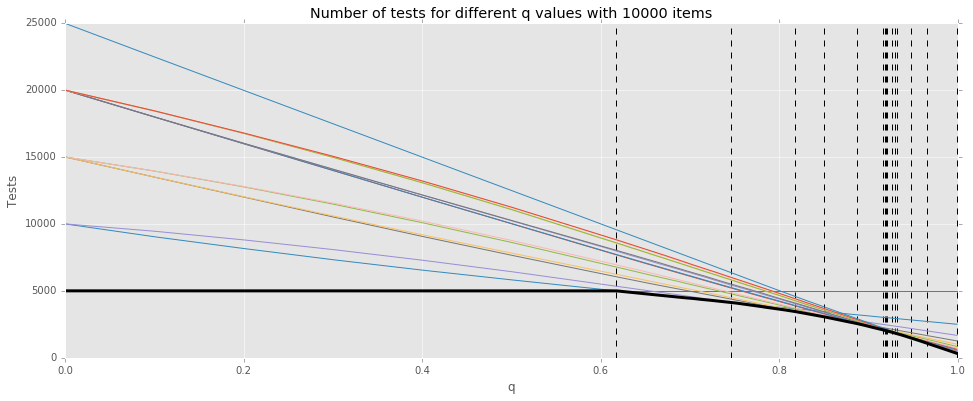

array([ 0.617,  0.746,  0.818,  0.85 ,  0.887,  0.916,  0.918,  0.919,
        0.921,  0.926,  0.93 ,  0.932,  0.948,  0.965,  0.999])

In [1020]:
fig, ax = plt.subplots()
for i, s in enumerate (strats):
    ax.plot(qs,mean_test[:,i], label=s.name)
ax.plot(qs, mean_test.min(axis=1), label="Minimum", lw=3, c="k")   
ax.set_title('Number of tests for different q values with 10000 items')
ax.set_xlabel('q')
ax.set_ylabel('Tests')
change = qs[min_change(mean_test)]
ax.vlines(change, 0, mean_test.max(), linestyles = '--')
# ax.legend()
plt.show()
change

In [1023]:
mean_test.argmin(axis=1)[min_change(mean_test)] + 1

array([ 1,  2,  3,  4,  5,  7,  8,  9,  8,  9,  8,  9, 11, 15, 16], dtype=int64)

In [1024]:
def min_change(arr):
    min_arr = arr.argmin(axis=1)
    roll = np.roll(min_arr,-1)
    change = roll - min_arr != 0
    return change
    
# min_change(mean_test) - np.roll(min_change(mean_test),-1) != 0
qs[min_change(mean_test)]

array([ 0.617,  0.746,  0.818,  0.85 ,  0.887,  0.916,  0.918,  0.919,
        0.921,  0.926,  0.93 ,  0.932,  0.948,  0.965,  0.999])